In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0
        self.integral = 0
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term
        derivative = (error - self.prev_error) / dt
        D = self.Kd * derivative
        
        # Save error for next derivative calculation
        self.prev_error = error
        
        # Compute output
        output = P + I + D
        
        return output
    
class PIDControllerWithAntiWindup(PIDController):
    def __init__(self, Kp, Ki, Kd, output_limits):
        super().__init__(Kp, Ki, Kd)
        self.output_min, self.output_max = output_limits
        
    def compute(self, setpoint, pv, dt):
        error = setpoint - pv
        
        # Proportional term
        P = self.Kp * error
        
        # Integral term with anti-windup
        self.integral += error * dt
        I = self.Ki * self.integral
        
        # Derivative term
        derivative = (error - self.prev_error) / dt
        D = self.Kd * derivative
        
        # Save error for next derivative calculation
        self.prev_error = error
        
        # Compute raw output
        output = P + I + D
        
        # Apply output limits
        output = max(self.output_min, min(self.output_max, output))
        
        # Anti-windup: only integrate if not saturated
        if output != P + I + D:
            self.integral -= error * dt  # undo the integration
        
        return output


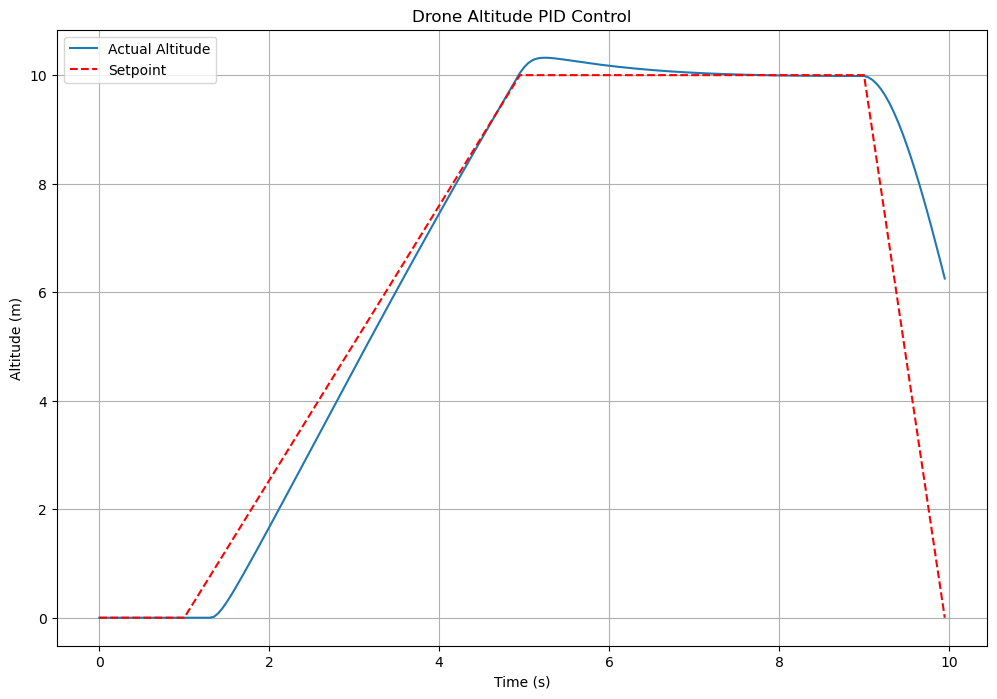

In [21]:
class Drone:
    def __init__(self):
        self.altitude = 0  # meters
        self.velocity = 0  # m/s
        self.mass = 1.0    # kg
        self.gravity = 9.81 # m/s²
        self.drag_coeff = 0.2
        
    def update(self, thrust, dt):
        # Net force: thrust - gravity - drag
        drag = self.drag_coeff * self.velocity * abs(self.velocity)
        net_force = thrust - self.mass * self.gravity - drag
        acceleration = net_force / self.mass
        self.velocity += acceleration * dt
        self.altitude += self.velocity * dt
        self.altitude = max(0, self.altitude)  # can't go below ground
        return self.altitude

# PID controller with anti-windup and filtered derivative
pid = PIDControllerWithAntiWindup(Kp=10, Ki=5, Kd=8, output_limits=(0, 30))

# Simulation parameters
dt = 0.05
total_time = 10
steps = int(total_time / dt)
time = np.arange(0, total_time, dt)
altitude = np.zeros_like(time)

# Setpoint trajectory: takeoff, hover, land
setpoint = np.zeros_like(time)
setpoint[20:100] = np.linspace(0, 10, 80)  # takeoff over 4 seconds
setpoint[100:180] = 10                     # hover for 4 seconds
setpoint[180:] = np.linspace(10, 0, len(time)-180)  # land over remaining time

# Create drone and run simulation
drone = Drone()

for i in range(1, len(time)):
    control = pid.compute(setpoint[i], drone.altitude, dt)
    altitude[i] = drone.update(control, dt)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(time, altitude, label='Actual Altitude')
plt.plot(time, setpoint, 'r--', label='Setpoint')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.title('Drone Altitude PID Control')
plt.legend()
plt.grid(True)
plt.show()